In [31]:
# Clone git repository
!rm -r .*
!git clone https://github.com/mujjingun/Deep-Compression-Tutorial .

Cloning into 'Deep-Compression-Tutorial'...


# Import packages

In [1]:
import math
import os
import io

import numpy as np

from scipy.sparse import csr_matrix, csc_matrix
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms

from collections import defaultdict, namedtuple
from heapq import heappush, heappop, heapify
import struct
from pathlib import Path
from tqdm import tqdm

# Load MNIST dataset

In [2]:
SEED = 42

BATCH_SIZE = 50  # input batch size for training
TEST_BATCH_SIZE = 1000  # input batch size for testing

# Control Seed
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Loader
kwargs = {'num_workers': 2, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=False, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Training and Test Loop

In [3]:
def train(model, epochs, learning_rate=0.01, log_interval=10):
    # NOTE : `weight_decay` term denotes L2 regularization loss term
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)
    initial_optimizer_state_dict = optimizer.state_dict()

    model.train()
    for epoch in range(epochs):
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for batch_idx, (data, target) in pbar:
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()

            optimizer.step()
            if batch_idx % log_interval == 0:
                done = batch_idx * len(data)
                percentage = 100. * batch_idx / len(train_loader)
                pbar.set_description(f'Train Epoch: {epoch} [{done:5}/{len(train_loader.dataset)} ({percentage:3.0f}%)]  Loss: {loss.item():.6f}')


def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
        print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)')
    return accuracy

# Network Architecture

In [4]:
class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.fc1 = torch.nn.Linear(784, 300)
        self.fc2 = torch.nn.Linear(300, 100)
        self.fc3 = torch.nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

In [6]:
model = LeNet().cuda()
model.load_state_dict(torch.load("initial_model_statedict.pth"))

print(model)
print(f"Total size = {sum(p.numel() * 4 for p in model.parameters())} bytes")

LeNet(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
Total size = 1066440 bytes


In [7]:
# Evaluate initial model performance
test(model)

Test set: Average loss: 0.1739, Accuracy: 9566/10000 (95.66%)


95.66

# Step 1. Modify the Model Code

Replace the `torch.nn.Linear` modules in `LeNet` by your custom linear module that applies a binary mask to the weights. 



In [11]:
class MaskedLinear(torch.nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)
        ##################################################
        #                    TODO
        # Define `self.mask` which represents a binary mask.
        ##################################################
    
    def forward(self, x):
        ##################################################
        #                    TODO
        # Apply `self.mask` to the weights before 
        # performing matrix multiplication.
        ##################################################
        return F.linear(x, self.weight, self.bias)

In [12]:
class MaskedLeNet(torch.nn.Module):
    def __init__(self):
        super(MaskedLeNet, self).__init__()
        ##################################################
        #                   TODO
        # Replace stock `torch.nn.Linear` with our custom
        # `MaskedLinear` module.
        ##################################################
        self.fc1 = torch.nn.Linear(784, 300)
        self.fc2 = torch.nn.Linear(300, 100)
        self.fc3 = torch.nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

In [13]:
# Utility function for reporting model size
def report_model_size(model, bits_per_weight=32):
    print(f"{'Layer':<15}{'Shape':<15}{'Size (bytes)':<15}{'Original Size (bytes)':<25}{'Size Reduction':<20}")
    print("="*90)
    
    total_cur_size = 0
    total_orig_size = 0
    
    for name, module in model.named_modules():
        if isinstance(module, MaskedLinear):
            cur_size = module.mask.sum().item()*bits_per_weight/8
            orig_size = module.weight.numel()*4
            print(f"{f'{name}.weight':<15}{f'[{module.weight.shape[0]}, {module.weight.shape[1]}]':<15}"
                  f"{cur_size:<15.0f}{orig_size:<25}"
                  f"{f'{1-cur_size/orig_size:.4f}%':<20}")
            total_cur_size += cur_size
            total_orig_size += orig_size
            
            cur_size = module.bias.numel()*4
            orig_size = module.bias.numel()*4
            print(f"{f'{name}.bias':<15}{f'[{module.bias.shape[0]}]':<15}"
                  f"{cur_size:<15.0f}{orig_size:<25}"
                  f"{f'{1-cur_size/orig_size:.4f}%':<20}")
            total_cur_size += cur_size
            total_orig_size += orig_size
    
    print("="*90)
    print(f"{'Total':<15}{'N/A':<15}{total_cur_size:<15.0f}{total_orig_size:<25}"
          f"{f'{1-total_cur_size/total_orig_size:.4f}%':<20}")

### Solution

In [14]:
class MaskedLinear(torch.nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)
        ##################################################
        #                    TODO
        # Define `self.mask` which represents a binary mask.
        ##################################################
        self.mask = torch.ones_like(self.weight).cuda()
    
    def forward(self, x):
        ##################################################
        #                    TODO
        # Apply `self.mask` to the weights before 
        # performing matrix multiplication.
        ##################################################
        masked_weight = self.weight * self.mask
        return F.linear(x, masked_weight, self.bias)

In [15]:
class MaskedLeNet(torch.nn.Module):
    def __init__(self):
        super(MaskedLeNet, self).__init__()
        ##################################################
        #                   TODO
        # Replace stock `torch.nn.Linear` with our custom
        # `MaskedLinear` module.
        ##################################################
        self.fc1 = MaskedLinear(784, 300)
        self.fc2 = MaskedLinear(300, 100)
        self.fc3 = MaskedLinear(100, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

### Test model

In [16]:
model = MaskedLeNet().cuda()
model.load_state_dict(torch.load("initial_model_statedict.pth"))

print(model)

MaskedLeNet(
  (fc1): MaskedLinear(in_features=784, out_features=300, bias=True)
  (fc2): MaskedLinear(in_features=300, out_features=100, bias=True)
  (fc3): MaskedLinear(in_features=100, out_features=10, bias=True)
)


In [17]:
# Evaluate initial model performance
test(model)
report_model_size(model)

Test set: Average loss: 0.1739, Accuracy: 9566/10000 (95.66%)
Layer          Shape          Size (bytes)   Original Size (bytes)    Size Reduction      
fc1.weight     [300, 784]     940800         940800                   0.0000%             
fc1.bias       [300]          1200           1200                     0.0000%             
fc2.weight     [100, 300]     120000         120000                   0.0000%             
fc2.bias       [100]          400            400                      0.0000%             
fc3.weight     [10, 100]      4000           4000                     0.0000%             
fc3.bias       [10]           40             40                       0.0000%             
Total          N/A            1066440        1066440                  0.0000%             


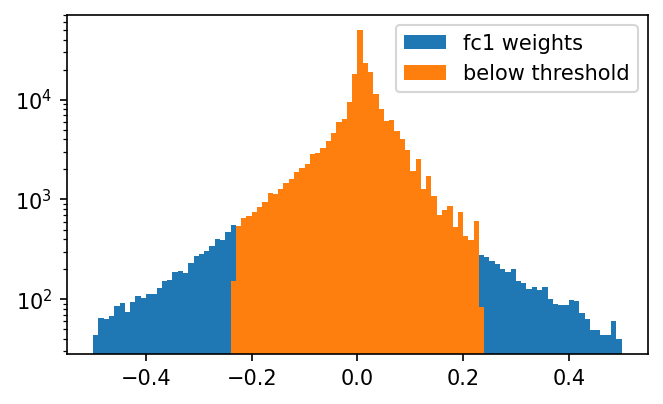

In [289]:
# Visualize weight distribution
plt.figure(figsize=(5, 3), dpi=150)
plt.yscale('log')

weights = model.fc1.weight.data.flatten().cpu()

plt.hist(weights, bins=100, range=(-.5, .5), label='fc1 weights')

std = torch.std(weights) * 2
weights_below_threshold = weights[abs(weights) < std]

plt.hist(weights_below_threshold, bins=100, range=(-.5, .5), label='below threshold')

plt.legend()

# Step 2. Pruning

Set the value of each module's `mask` to 0 wherever the absolute value of the corresponding weight does not exceed the threshold.

The threshold value is computed by `sensitivity * (standard deviation of layer weights)`.

In [ ]:
def prune_by_std(model, sensitivity=2.0):
    for name, module in model.named_modules():
        if isinstance(module, MaskedLinear):
            #####################################
            #               TODO
            # Compute threshold
            #####################################
            threshold = # TODO

            #####################################
            #               TODO
            # Compute new mask
            #####################################
            new_mask = # TODO

            #####################################
            #               TODO
            # Copy new mask back to `module.mask`
            #####################################
            

### Solution

In [97]:
def prune_by_std(model, sensitivity=2.0):
    for name, module in model.named_modules():
        if isinstance(module, MaskedLinear):
            #####################################
            #               TODO
            # Compute threshold
            #####################################
            std = torch.std(module.weight.data)
            threshold = std * sensitivity

            #####################################
            #               TODO
            # Compute new mask
            #####################################
            new_mask = torch.where(
                abs(module.weight) < threshold, 
                torch.zeros_like(module.mask), 
                module.mask
            )

            #####################################
            #               TODO
            # Apply new mask to `module.mask`
            #####################################
            module.mask.copy_(new_mask)
            module.weight.data.copy_(module.weight.data * new_mask)

### Call function

In [184]:
prune_by_std(model, 2.0)

In [185]:
# Evaluate initial model performance
test(model)
report_model_size(model)

Test set: Average loss: 1.0589, Accuracy: 7542/10000 (75.42%)
Layer          Shape          Size (bytes)   Original Size (bytes)    Size Reduction      
fc1.weight     [300, 784]     41904          940800                   0.9555%             
fc1.bias       [300]          1200           1200                     0.0000%             
fc2.weight     [100, 300]     5100           120000                   0.9575%             
fc2.bias       [100]          400            400                      0.0000%             
fc3.weight     [10, 100]      328            4000                     0.9180%             
fc3.bias       [10]           40             40                       0.0000%             
Total          N/A            48972          1066440                  0.9541%             


### Retrain model

In [186]:
train(model, 5)

Train Epoch: 0 [59500/60000 ( 99%)]  Loss: 0.271104: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:08<00:00, 143.74it/s]
Train Epoch: 1 [59500/60000 ( 99%)]  Loss: 0.071051: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:07<00:00, 153.23it/s]
Train Epoch: 2 [59500/60000 ( 99%)]  Loss: 0.275658: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:08<00:00, 147.18it/s]
Train Epoch: 3 [59500/60000 ( 99%)]  Loss: 0.069647: 100%|█████████████████████████████████████████████████████████████████████████████████████████████

In [200]:
test(model)
report_model_size(model)

Test set: Average loss: 0.1153, Accuracy: 9662/10000 (96.62%)
Layer          Shape          Size (bytes)   Original Size (bytes)    Size Reduction      
fc1.weight     [300, 784]     41904          940800                   0.9555%             
fc1.bias       [300]          1200           1200                     0.0000%             
fc2.weight     [100, 300]     5100           120000                   0.9575%             
fc2.bias       [100]          400            400                      0.0000%             
fc3.weight     [10, 100]      328            4000                     0.9180%             
fc3.bias       [10]           40             40                       0.0000%             
Total          N/A            48972          1066440                  0.9541%             


In [197]:
# Save checkpoint
torch.save({
    'state_dict': model.state_dict(),
    'mask1': model.fc1.mask,
    'mask2': model.fc2.mask,
    'mask3': model.fc3.mask
}, "pruned_model_statedict.pth")

# Step 3. Quantization

Hint: use the `csr_matrix` function to convert between sparse weights and dense weights.
Note: You need to convert the PyTorch tensor to Numpy array first.

Example:
```python
mat = np.array([[0, 0, 1], [0, 2, 0]])
mat = csr_matrix(mat)

# Extract only the nonzero elements
mat.data  # Output: array([1, 2])

# Assign to the nonzero elements of `mat`
mat.data = np.array([3, 4])

# Convert back to dense representation
mat = mat.toarray()  # Output: array([[0, 0, 3], [0, 4, 0]])
```

Hint2: Use the `Kmeans` function to cluster similar weights together.

Example:
```python
kmeans = KMeans(n_clusters=2)
kmeans.fit(np.array([[10], [1], [2], [11], [12], [3]]))

# Obtain the center values of each cluster
kmeans.cluster_centers_  # Output: array([2, 11])

# Obtain which cluster each element belongs to
kmeans.labels_  # Output: array([1, 0, 0, 1, 1, 0])
```

In [20]:
def quantize_weights(model, bits=5):
    for name, module in model.named_modules():
        if isinstance(module, MaskedLinear):
            weight = (module.weight.data * module.mask).cpu().numpy()
            
            ########################################
            #                 TODO
            # Quantize each weight of the module
            # with the specified number of bits
            ########################################

### Solution

In [21]:
def quantize_weights(model, bits=5):
    for name, module in model.named_modules():
        if isinstance(module, MaskedLinear):
            weight = (module.weight.data * module.mask).cpu().numpy()
            
            mat = csr_matrix(weight)

            kmeans = KMeans(n_clusters=2**bits)
            kmeans.fit(mat.data.reshape(-1,1))

            new_weight = kmeans.cluster_centers_[kmeans.labels_].reshape(-1)
            mat.data = new_weight
            module.weight.data.copy_(torch.from_numpy(mat.toarray()).cuda())

### Call function

In [22]:
# Load checkpoint from step 1 (optional)
ckpt = torch.load("pruned_model_statedict.pth")
model.load_state_dict(ckpt['state_dict'])
model.fc1.mask.copy_(ckpt['mask1'])
model.fc2.mask.copy_(ckpt['mask2'])
model.fc3.mask.copy_(ckpt['mask3']);

In [23]:
quantize_weights(model)

In [24]:
# Evaluate quantized model performance
test(model)
report_model_size(model, bits_per_weight=5)

Test set: Average loss: 0.1153, Accuracy: 9662/10000 (96.62%)
Layer          Shape          Size (bytes)   Original Size (bytes)    Size Reduction      
fc1.weight     [300, 784]     6548           940800                   0.9930%             
fc1.bias       [300]          1200           1200                     0.0000%             
fc2.weight     [100, 300]     797            120000                   0.9934%             
fc2.bias       [100]          400            400                      0.0000%             
fc3.weight     [10, 100]      51             4000                     0.9872%             
fc3.bias       [10]           40             40                       0.0000%             
Total          N/A            9036           1066440                  0.9915%             


In [25]:
# Save checkpoint
torch.save({
    'state_dict': model.state_dict(),
    'mask1': model.fc1.mask,
    'mask2': model.fc2.mask,
    'mask3': model.fc3.mask
}, "quantized_model_statedict.pth")

# Step 4. Huffman Coding

In [30]:
from huffman import huffman_encode_model, huffman_decode_model

huffman_encode_model(model)

print("Loading Huffman coded model")
huffman_decode_model(model)

print("Testing")
test(model)

Layer           |   original compressed improvement percent
----------------------------------------------------------------------
fc1.weight      |      85012      20284       4.19x  23.86%
fc1.bias        |       1200       1200       1.00x 100.00%
fc2.weight      |      10604       3079       3.44x  29.04%
fc2.bias        |        400        400       1.00x 100.00%
fc3.weight      |        700        443       1.58x  63.29%
fc3.bias        |         40         40       1.00x 100.00%
----------------------------------------------------------------------
total           |      97956      25446       3.85x  25.98%
Loading Huffman coded model
Testing
Test set: Average loss: 0.1153, Accuracy: 9662/10000 (96.62%)


96.62

In [28]:
# Check saved file size (in bytes)
!du -b encodings

31075	encodings


In [29]:
# calculate reduction in size
# You should get around 97% reduction
1 - 31075 / 1066440

0.9708609954615356